## **Method of Unbiased Estimators**

Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5659690467417032
Epoch 200, Unbiased Loss: 0.5449741116650932
Epoch 300, Unbiased Loss: 0.537702152078586
Epoch 400, Unbiased Loss: 0.5345323891526399
Epoch 500, Unbiased Loss: 0.532983634496632
Epoch 600, Unbiased Loss: 0.5321742651630121
Epoch 700, Unbiased Loss: 0.5317313863639453
Epoch 800, Unbiased Loss: 0.5314801012287301
Epoch 900, Unbiased Loss: 0.5313329085443945
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.47682145585215474
Epoch 200, Unbiased Loss: 0.43999344591385814
Epoch 300, Unbiased Loss: 0.42610839636219583
Epoch 400, Unbiased Loss: 0.4193455353891484
Epoch 500, Unbiased Loss: 0.4156040797361768
Epoch 600, Unbiased Loss: 0.41336518559853347
Epoch 700, Unbiased Loss: 0.4119493971384233
Epoch 800, Unbiased Loss: 0.4110160002430517
Epoch 900, Unbiased Loss: 0.41038039421508715
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5524745260440368
Epoch 200, Un

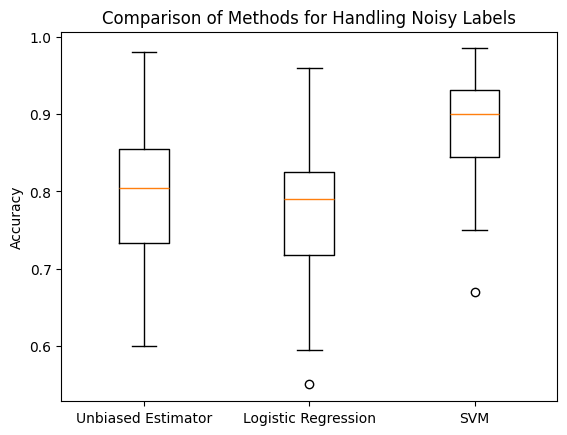

In [6]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        """
        Generate a synthetic dataset with noisy labels.
        """
        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=4, n_informative=6, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)
        
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self, seed):
        """
        Return the generated data.
        """
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Define the Noise Transition Matrix
def define_noise_transition_matrix(noise_rate_positive, noise_rate_negative):
    T = np.array([[1 - noise_rate_negative, noise_rate_negative],
                  [noise_rate_positive, 1 - noise_rate_positive]])
    return T

# Unbiased logistic loss function
def unbiased_log_loss(y_true, y_pred, T):
    rho_minus = T[0, 1]
    rho_plus = T[1, 0]
    log_loss = np.logaddexp(0, -y_true * y_pred)
    log_loss_neg = np.logaddexp(0, y_true * y_pred)
    unbiased_loss = ((1 - rho_minus) * log_loss - rho_plus * log_loss_neg) / (1 - rho_plus - rho_minus)
    return np.mean(unbiased_loss)

# Logistic loss function and its gradient
def logistic_loss_and_grad(X, y, w):
    z = np.dot(X, w)
    loss = np.logaddexp(0, -y * z)
    grad = -y[:, np.newaxis] * X / (1 + np.exp(y * z))[:, np.newaxis]
    return np.mean(loss), np.mean(grad, axis=0)

# Custom training loop that minimizes the unbiased loss using gradient descent
def train_custom_logistic_regression(X, y, T, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for epoch in range(epochs):
        z = np.dot(X, w)
        unbiased_loss_value = unbiased_log_loss(y, z, T)
        _, grad = logistic_loss_and_grad(X, y, w)
        w -= learning_rate * grad
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Unbiased Loss: {unbiased_loss_value}')
    return w

# Main simulation function
def simulation_study(n_datasets=100, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, y_test_noisy = train_test_split(X, y_noisy, test_size=test_size, random_state=seed_i)
        
        T = define_noise_transition_matrix(noise_rate_positive, noise_rate_negative)
        
        # Train logistic regression with unbiased loss
        weights = train_custom_logistic_regression(X_train, y_train_noisy, T, learning_rate, epochs)
        y_pred_weighted_lr = np.sign(np.dot(X_test, weights))
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Train logistic regression without reweighting
        clf_logistic = LogisticRegression()
        clf_logistic.fit(X_train, y_train_noisy)
        y_pred_logistic = clf_logistic.predict(X_test)
        accuracy_logistic = accuracy_score(y_test_clean, y_pred_logistic)
        accuracies_unweighted_lr.append(accuracy_logistic)
        
        # Train SVM without reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
        
    print(f"Simulation Study: n_samples={n_samples}, n_features={n_features}, noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}")
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Unbiased Estimator', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)

Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=10, n_samples=1000
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.4634197118336731
Epoch 200, Unbiased Loss: 0.4341953101725835
Epoch 300, Unbiased Loss: 0.42409415638041154
Epoch 400, Unbiased Loss: 0.4195088054093848
Epoch 500, Unbiased Loss: 0.41711204039375865
Epoch 600, Unbiased Loss: 0.41574472746269536
Epoch 700, Unbiased Loss: 0.414914998607448
Epoch 800, Unbiased Loss: 0.41438676102905453
Epoch 900, Unbiased Loss: 0.4140370217151257
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.4427744428428666
Epoch 200, Unbiased Loss: 0.3974316372244263
Epoch 300, Unbiased Loss: 0.37876741141186543
Epoch 400, Unbiased Loss: 0.36889648036203243
Epoch 500, Unbiased Loss: 0.3629984942618414
Epoch 600, Unbiased Loss: 0.3592122530395784
Epoch 700, Unbiased Loss: 0.3566632198073465
Epoch 800, Unbiased Loss: 0.35488718066257513
Epoch 900, Unbiased Loss: 0.353616817148

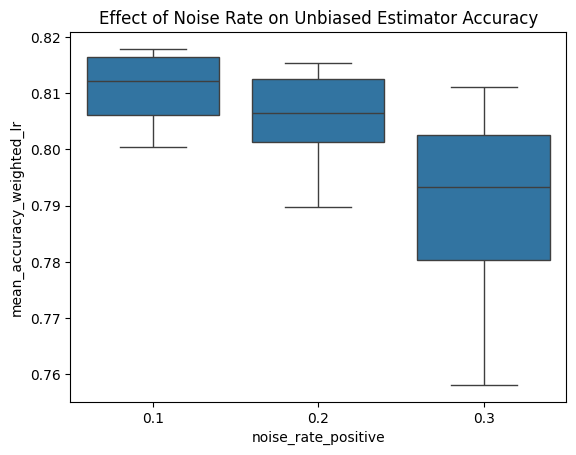

In [7]:
def simulation_study_multiple_configs_unbiased(noise_rate_positives, noise_rate_negatives, n_features_list, n_samples_list, n_datasets=100, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    results = []

    for noise_rate_positive, noise_rate_negative in zip(noise_rate_positives, noise_rate_negatives):
        for n_features in n_features_list:
            for n_samples in n_samples_list:
                print(f"Running simulation for noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}, n_features={n_features}, n_samples={n_samples}")

                accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(
                    n_datasets=n_datasets,
                    n_samples=n_samples,
                    n_features=n_features,
                    noise_rate_positive=noise_rate_positive,
                    noise_rate_negative=noise_rate_negative,
                    test_size=test_size,
                    learning_rate=learning_rate,
                    epochs=epochs,
                    seed=seed
                )
                print("Simulation run successful.")

                # Store the results with the corresponding parameters
                results.append({
                    'noise_rate_positive': noise_rate_positive,
                    'noise_rate_negative': noise_rate_negative,
                    'n_features': n_features,
                    'n_samples': n_samples,
                    'mean_accuracy_weighted_lr': np.mean(accuracies_weighted_lr),
                    'std_accuracy_weighted_lr': np.std(accuracies_weighted_lr),
                    'mean_accuracy_unweighted_lr': np.mean(accuracies_unweighted_lr),
                    'std_accuracy_unweighted_lr': np.std(accuracies_unweighted_lr),
                    'mean_accuracy_svm': np.mean(accuracies_svm),
                    'std_accuracy_svm': np.std(accuracies_svm)
                })
    
    return results

# Example usage:
noise_rate_positives = [0.1, 0.2, 0.3]
noise_rate_negatives = [0.1, 0.2, 0.3]
n_features_list = [10, 20, 30]
n_samples_list = [1000, 2000, 3000]

results_unbiased = simulation_study_multiple_configs_unbiased(noise_rate_positives, noise_rate_negatives, n_features_list, n_samples_list, n_datasets=100, seed=42)

import pandas as pd
import seaborn as sns

# Convert results to DataFrame for easier analysis
df_results_unbiased = pd.DataFrame(results_unbiased)

# Example of how to visualize the effect of noise rate on accuracy
sns.boxplot(x='noise_rate_positive', y='mean_accuracy_weighted_lr', data=df_results_unbiased)
plt.title("Effect of Noise Rate on Unbiased Estimator Accuracy")
plt.show()


#### UCI Benchmark Dataset

Epoch 0, Unbiased Loss: 0.6931471805599453
Epoch 100, Unbiased Loss: 0.43598958160379525
Epoch 200, Unbiased Loss: 0.4105139591158709
Epoch 300, Unbiased Loss: 0.4025506218432499
Epoch 400, Unbiased Loss: 0.3988841841601849
Epoch 500, Unbiased Loss: 0.3966931506465988
Epoch 600, Unbiased Loss: 0.3951170917042277
Epoch 700, Unbiased Loss: 0.39383957929522145
Epoch 800, Unbiased Loss: 0.39273011165392063
Epoch 900, Unbiased Loss: 0.3917299193953113
Epoch 0, Unbiased Loss: 0.6931471805599453
Epoch 100, Unbiased Loss: 0.4626852021536586
Epoch 200, Unbiased Loss: 0.4385054316123544
Epoch 300, Unbiased Loss: 0.42982381501731115
Epoch 400, Unbiased Loss: 0.4251681408289995
Epoch 500, Unbiased Loss: 0.4220745806918174
Epoch 600, Unbiased Loss: 0.4197523913498496
Epoch 700, Unbiased Loss: 0.4178803633538199
Epoch 800, Unbiased Loss: 0.4163050008155694
Epoch 900, Unbiased Loss: 0.4149428598777183
Epoch 0, Unbiased Loss: 0.6931471805599453
Epoch 100, Unbiased Loss: 0.4820218571994495
Epoch 200, U

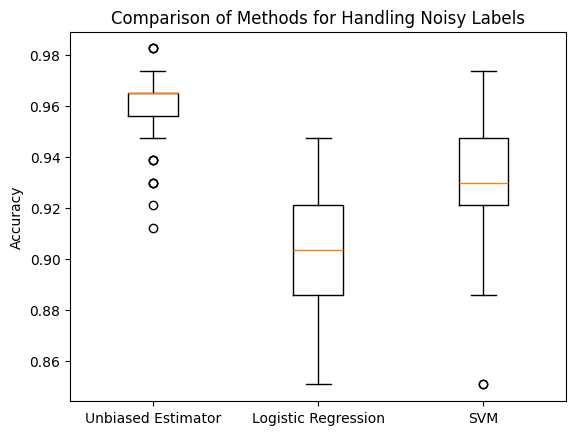

In [2]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def load_and_preprocess_data(self):
        """
        Load and preprocess the UCI dataset.
        """
        # Load dataset
        data = load_breast_cancer()
        self.X = data.data
        self.y = data.target
        
        # Standardize the features
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        
        # Convert labels from {0, 1} to {-1, 1}
        self.y = np.where(self.y == 0, -1, 1)
    
    def introduce_noise(self):
        """
        Introduce noise into the labels.
        """
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self):
        """
        Return the data with noisy labels.
        """
        self.load_and_preprocess_data()
        self.introduce_noise()
        return self.X, self.y, self.y_noisy

# Define the Noise Transition Matrix
def define_noise_transition_matrix(noise_rate_positive, noise_rate_negative):
    T = np.array([[1 - noise_rate_negative, noise_rate_negative],
                  [noise_rate_positive, 1 - noise_rate_positive]])
    return T

# Unbiased logistic loss function
def unbiased_log_loss(y_true, y_pred, T):
    rho_minus = T[0, 1]
    rho_plus = T[1, 0]
    log_loss = np.logaddexp(0, -y_true * y_pred)
    log_loss_neg = np.logaddexp(0, y_true * y_pred)
    unbiased_loss = ((1 - rho_minus) * log_loss - rho_plus * log_loss_neg) / (1 - rho_plus - rho_minus)
    return np.mean(unbiased_loss)

# Logistic loss function and its gradient
def logistic_loss_and_grad(X, y, w):
    z = np.dot(X, w)
    loss = np.logaddexp(0, -y * z)
    grad = -y[:, np.newaxis] * X / (1 + np.exp(y * z))[:, np.newaxis]
    return np.mean(loss), np.mean(grad, axis=0)

# Custom training loop that minimizes the unbiased loss using gradient descent
def train_custom_logistic_regression(X, y, T, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for epoch in range(epochs):
        z = np.dot(X, w)
        unbiased_loss_value = unbiased_log_loss(y, z, T)
        _, grad = logistic_loss_and_grad(X, y, w)
        w -= learning_rate * grad
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Unbiased Loss: {unbiased_loss_value}')
    return w

# Main simulation function
def simulation_study(n_datasets=100, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(noise_rate_positive, noise_rate_negative, seed)
    
    for i in range(n_datasets):
        X, y, y_noisy = simulation.get_data()
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, y_test_noisy = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)
        
        T = define_noise_transition_matrix(noise_rate_positive, noise_rate_negative)
        
        # Train logistic regression with unbiased loss
        weights = train_custom_logistic_regression(X_train, y_train_noisy, T, learning_rate, epochs)
        y_pred_weighted_lr = np.sign(np.dot(X_test, weights))
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Train logistic regression without reweighting
        clf_logistic = LogisticRegression()
        clf_logistic.fit(X_train, y_train_noisy)
        y_pred_logistic = clf_logistic.predict(X_test)
        accuracy_logistic = accuracy_score(y_test_clean, y_pred_logistic)
        accuracies_unweighted_lr.append(accuracy_logistic)
        
        # Train SVM without reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Unbiased Estimator', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)